# Sujet 1 : Concentration de CO2 dans l'atmosphère depuis 1958

Charles David Keeling a lancé une campagne de mesure de la concentration de C02 dans l'atmosphère. Il a installé ces instrument à l'observatoire de Mauna Loa, Hawaii, Etats-Unis. Depuis 1958, nous avons continuellement des données.

L'étude initiale devait étudier les variations saisonnière de la concentration, mais avec le réchauffement climatique, elle se tourne maintenant sur la croissance de la concentration.

A partir des données hebdomadaires disponible sur le [site Web de l'institut Scripps](https://scrippsco2.ucsd.edu/data/atmospheric_co2/primary_mlo_co2_record.html), nous souhaitons reproduire l'analyse de l'évolution de la concentration de C02 dans l'atmosphère pour faire un modèle prédictif.

## Environnement de travail

Nous définions quelques fonctions pour faciliter l'affichage des numéros de version associés à notre système et à nos modules. 

In [1]:
def print_imported_modules():
    import sys
    print("Imported modules")
    for name, val in sorted(sys.modules.items()):
        if(hasattr(val, '__version__')): 
            print("\t",val.__name__, val.__version__)
            
def print_sys_info():
    import sys
    import platform
    print("System Info")
    print("\t",sys.version)
    print("\t",platform.uname())

Nous utilisons les modules usuels en traitement des données sous le langage python3 à la date du *6 Avril 2020* : numpy, pandas, seaborn, matplotlib, statsmodels, ...   

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

Ci-aprés un aperçu de notre environnement d'execution pour les personnes qui souhaiteraient reproduire ces travaux sur leur machine.

In [3]:
print_sys_info()
print_imported_modules()

System Info
	 3.6.4 |Anaconda, Inc.| (default, Mar 13 2018, 01:15:57) 
[GCC 7.2.0]
	 uname_result(system='Linux', node='dc160b48d9b7', release='4.4.0-164-generic', version='#192-Ubuntu SMP Fri Sep 13 12:02:50 UTC 2019', machine='x86_64', processor='x86_64')
Imported modules
	 IPython 7.12.0
	 IPython.core.release 7.12.0
	 PIL 7.0.0
	 PIL.Image 7.0.0
	 PIL._version 7.0.0
	 _csv 1.0
	 _ctypes 1.1.0
	 _curses b'2.2'
	 decimal 1.70
	 argparse 1.1
	 backcall 0.1.0
	 cffi 1.13.2
	 csv 1.0
	 ctypes 1.1.0
	 cycler 0.10.0
	 dateutil 2.8.1
	 decimal 1.70
	 decorator 4.4.1
	 distutils 3.6.4
	 ipaddress 1.0
	 ipykernel 5.1.4
	 ipykernel._version 5.1.4
	 ipython_genutils 0.2.0
	 ipython_genutils._version 0.2.0
	 ipywidgets 7.2.1
	 ipywidgets._version 7.2.1
	 jedi 0.16.0
	 json 2.0.9
	 jupyter_client 6.0.0
	 jupyter_client._version 6.0.0
	 jupyter_core 4.6.3
	 jupyter_core.version 4.6.3
	 kiwisolver 1.1.0
	 logging 0.5.1.2
	 matplotlib 2.2.3
	 matplotlib.backends.backend_agg 2.2.3
	 numpy 1.15.2
	 n

## Chargement et inspection des données

Nous avons récupérer les données hebdomadaire le *6 Avril 2020* depuis le lien suivant : [https://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/weekly/weekly_in_situ_co2_mlo.csv](https://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/weekly/weekly_in_situ_co2_mlo.csv)

In [4]:
filename = "./weekly_in_situ_co2_mlo.csv"

Nous affichons les premières lignes du fichier pour repérer d'éventuelle lignes à ignorer.

In [5]:
def head(filename,n):
    with open(filename,"r") as f:
        lignes = f.readlines()
    n = min(n,len(lignes))
    for i,ligne in enumerate(lignes[:n]):
        print("Ligne",i,":",ligne,end="")
head(filename,5)

Ligne 0 : "-------------------------------------------------------------------------------------------"
Ligne 1 : " Atmospheric CO2 concentrations (ppm) derived from in situ air measurements                "
Ligne 2 : " at Mauna Loa, Observatory, Hawaii: Latitude 19.5°N Longitude 155.6°W Elevation 3397m      "
Ligne 3 : "                                                                                           "
Ligne 4 : " Source: R. F. Keeling, S. J. Walker, S. C. Piper and A. F. Bollenbacher                   "


Le fichier semble être correctement formaté :
* Les lignes de commentaire/metadonnée commencent par "
* Les données ne commencent pas par "

Trouvons donc la première ligne de données.

In [6]:
def find_num_first_dataline(filename):
    with open(filename,"r") as f:
        lignes = f.readlines()
    for i,ligne in enumerate(lignes):
        if ligne[0] != '"':
            return i
    raise Exception("No dataline found")
find_num_first_dataline(filename)

44

Aprés une inspection visuelle, nous avons aussi trouvé que les données commence ligne 44.
Lors de cette inspection, nous avons pu relever les informations suivantes :
1. La première colonne correspond aux dates d'acquisition
2. Les données sont centrées sur 12h00 chaque jour
3. La seconde colonne correspond aux concentrations mesurées
4. La concentration est la concentration moyenne de C02 dans l'atomosphère de la journée

In [7]:
data = pd.read_csv(filename,skiprows=44,header=None,names=["Date","Concentration"])
data

Date  Concentration
0     1958-03-29         316.19
1     1958-04-05         317.31
2     1958-04-12         317.69
3     1958-04-19         317.58
4     1958-04-26         316.48
5     1958-05-03         316.95
6     1958-05-17         317.56
7     1958-05-24         317.99
8     1958-07-05         315.85
9     1958-07-12         315.85
10    1958-07-19         315.46
11    1958-07-26         315.59
12    1958-08-02         315.64
13    1958-08-09         315.10
14    1958-08-16         315.09
15    1958-08-30         314.14
16    1958-09-06         313.54
17    1958-11-08         313.05
18    1958-11-15         313.26
19    1958-11-22         313.57
20    1958-11-29         314.01
21    1958-12-06         314.56
22    1958-12-13         314.41
23    1958-12-20         314.77
24    1958-12-27         315.21
25    1959-01-03         315.24
26    1959-01-10         315.50
27    1959-01-17         315.69
28    1959-01-24         315.86
29    1959-01-31         315.42
...          ...            ...
3126  2019-07-06         412.69
3127  2019-07-13         412.30
3128  2019-07-20         411.76
3129  2019-07-27         410.32
3130  2019-08-03         410.50
3131  2019-08-10         410.48
3132  2019-08-17         410.05
3133  2019-08-24         409.52
3134  2019-08-31         409.32
3135  2019-09-07         408.80
3136  2019-09-14         408.61
3137  2019-09-21         408.50
3138  2019-09-28         408.28
3139  2019-10-05         407.99
3140  2019-10-12         408.61
3141  2019-10-19         408.77
3142  2019-10-26         408.68
3143  2019-11-02         409.86
3144  2019-11-09         410.15
3145  2019-11-16         410.22
3146  2019-11-23         410.48
3147  2019-11-30         410.92
3148  2019-12-07         411.27
3149  2019-12-14         411.67
3150  2019-12-21         412.30
3151  2019-12-28         412.59
3152  2020-01-04         413.19
3153  2020-01-11         413.39
3154  2020-01-25         413.36
3155  2020-02-01         413.99

[3156 rows x 2 columns]

Nous y somme presque. Il ne reste plus qu'à convertir les dates en Period Pandas.

In [35]:
def convert_date(year_month_day):
    year_month_day_str = str(year_month_day)
    year = int(year_month_day[:4])
    month = int(year_month_day[5:7])
    day = int(year_month_day[8:])
    return pd.Timestamp(year=year,month=month,day=day,hour=12,minute=0,second=0)

data["Datetime"] = [convert_date(ymd) for ymd in data["Date"]]
data["Timestamp"] = [date.value/10**8 for date in data["Datetime"]]
data["Period"] = [date.to_period('W') for date in data["Datetime"]]
data.set_index("Period");

Il faut retenir les élèments suivants :

| Nom           | Signification                        |
|:-------------:|:-------------------------------------|
|**Date**       | La date donnée dans le fichier brute |
|**Datetime**   | La date au format ISO-8601           |
|**Timestamp**  | Temps unix                           |
|**Period**     | Plage de temps                       |

Et un petit graphique pour guider notre travail.

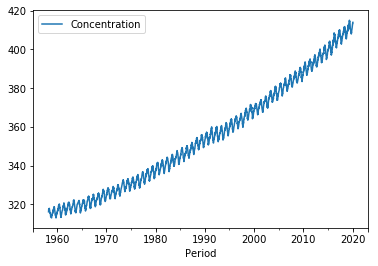

In [36]:
data.plot(x="Period",y="Concentration")
plt.show()

## Décomposition de la concentration

Sur le graphique, nous aperçevons une courbe croissante avec de faible oscilliations. Cette courbe se prête bien à une décompostion en saisonière.

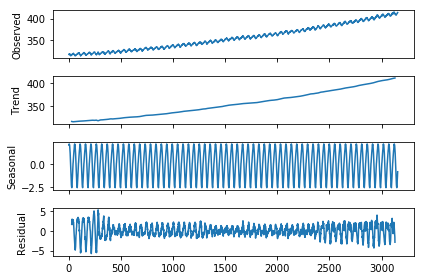

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose
# freq = 52 car 52 semaines par an
result = seasonal_decompose(data['Concentration'],model="additive", freq=52)
result.plot()
plt.show()

La tendance globale (Trend) de la concentration moyenne de C02 dans l'atmosphère est croissante.

Les oscillations semblent bien être saisonières (Seasonal).

**Nous noterons cependant que le bruit résiduel (Residual) est du même ordre que les oscillations saisonnières**

## Modélisation du phénomène

Au regard de la décomposition précédente, nous modéliserons la variation de la concentration comme la somme d'une fonction affine croissante et d'une fonction périodique.

### Estimation de la fonction linéaire

Pour estimer notre fonction affine, nous allons utiliser un modlèle linéaire génralisé : Concentration ~ 1 + Temps

In [37]:
data["Intercept"]=1
linmodel = sm.GLM(data['Concentration'],data[['Intercept','Timestamp']]).fit()
linmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:          Concentration   No. Observations:                 3156
Model:                            GLM   Df Residuals:                     3154
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                          18.461
Method:                          IRLS   Log-Likelihood:                -9078.1
Date:                Tue, 07 Apr 2020   Deviance:                       58226.
Time:                        13:14:18   Pearson chi2:                 5.82e+04
No. Iterations:                     3   Covariance Type:             nonrobust
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    324.5375      0.114   2845.850      0.000     324.314     324.761
Timestamp       5e-09   1.37e-11    364.652      0.000    4.97e-09    5.03e-09
==============================================================================
"""

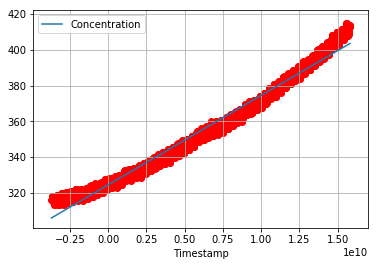

In [42]:
%matplotlib inline
data_pred = pd.DataFrame({'Timestamp': np.linspace(start=data["Timestamp"][0], stop=data["Timestamp"][len(data["Timestamp"])-1], num=50), 'Intercept': 1})
data_pred['Concentration'] = linmodel.predict(data_pred)
data_pred.plot(x="Timestamp",y="Concentration",kind="line")
plt.scatter(x=data["Timestamp"],y=data["Concentration"],color="red")
plt.grid(True)

## Prédiction en 2050

Nous allons contruire une fonction pour prédire la concentration à une date donnée.

In [61]:
def predict(year=2050,month=6,day=4,hour=12,minute=0,second=0):
    datetime = pd.Timestamp(year=year,month=month,day=day,hour=hour,minute=minute,second=second)
    timestamp = datetime.value
    date_pred = pd.DataFrame({'Timestamp':[timestamp],'Intercept':1},index=[datetime])
    return linmodel.predict(date_pred)
predict()

2050-06-04 12:00:00    1.269077e+10
dtype: float64

La concentration de C02 de l'atmosphère en 2050 sera de 10 Gppm

## Conclusion

La droite que nous avons pris pour faire nos prédictions se trouve sous les mesures réelles. Cela signifie que la réalité pourrait être encore pire dans le future. Cependant, notre prédiction présentée ici est plein de biais : le plus important reste sans doute qu'il s'appuie sur un modèle linéaire.